# tf.image.crop_and_resize (cortar y redimensionar)

Extrae los recortes desde el tensor de la imagen de entrada y los redimensiona de forma bilineal (dos lineas) (posiblemente con un cambio de relacion de aspecto) a un tamaño de salida común especificado por __[tamaño_del_recorte]__ ó __[crop_size]__.   Esto es mas general que la opción __[recorte_en_cuadro_delimitador]__ ó __crop_to_bounding_box__, el cual extrae un segmento de tamaño fijo desde la imagen de entrada y no permite cambiar el tamaño o la relación de aspecto.

Retorna un tensor con __recortes__ ó __crops__ desde la imagen de entrada en las posiciones definidas en las ubicaciones del cuadro delimitador en los recuadros.

Los cuadros recortados son redimensionados a un tamaño fijo igual a __[alto_del_recorte, ancho_del_recorte]__ ó __[crop_height, crop_width]__.  El resultado es un tensor 4-D igual a __[numero_de_recuadros, alto_del_recorte, ancho_del_recorte, profundidad]__ ó __[num_boxes, crop_height, crop_width, depth].__  

El redimensionamiento es alineado en la esquina. Particularmente, si los cuadros son igual a [[0,0,1,1]] el metodo podria darnos un resultados identicos si se utiliza __tf.image.resize_bilinear()__ con __align_corners=True__

## Sintaxis.

tf.image.crop_and_resize(
    image,
    boxes,
    box_ind,
    crop_size,
    method='bilinear',
    extrapolation_value=0,
    name=None
)

## Argumentos

__Imagen ó Image:__ Es un tensor.  El tipo de datos puede ser uno de los siguientes: __uint8, uint16, uint8, int32, int64, half, float32, float64.__   Un tensor 4-D de forma __[lote, altura de la imagen, ancho de la imagen, profundidad]__ ó __[batch, image_height, image_width, depth].__  La altura y el ancho necesitan ser positivos.


__Recuadros ó Boxes:__ Es un tensor de tipo __float32__.   Un tensor 2-D con forma __[numero de recuadros, 4]__ ó __[num_boxes, 4].__  La i-esima fila del tensor especifica las coorderandas de un recuadro en la imagen __box_ind[i]__ y se especifica en las coordenadas normalizadas __[y1, x1, y2, x2]__.   

Un valor de coordenada normalizado __"y"__ es mapeado a las coordenadas de la imagen en __"y * (altura_de_la_imagen - 1)__ ó __y * (image_height - 1)__, asi como el intervalo __[0,1]__ de la altura de la imagen normalizada es mapeada a __[0, altura de la image]__ ó __[0, image_height]__ en las coordenadas de altura de la imagen.  Nosotros permitimos y1 > y2, en cuyo caso el recorte muestreado es una version invertida de arriba-abajo de una imagen original.   La dimension de ancho es tratada de forma similar.  Coordenadas normalizada fuera del rango __[0, 1]__ son permitidas, en cuyo caso lo usemos __extrapolation_value__ en extrapolar los valores de la imagen de entrada.

__Box_ind:__ Es un tensor de tipo __int32__.  Un tensor 1-D de forma __[numero_de_recuadros]__ ó __[num_boxes]__ con values __int32__ en __[0, lote]__ ó __[0, batch]__.   El valor de __box_ind[i]__ especifica la imagen a la que se refiere el cuadro __í-th__.

__tamaño del recorte ó Crop_size:__ Es un tensor de tipo __int32__. Un tensor 1-D de dos elementos, __tamaño = [alto_del_recorte, ancho_del_recorte]__ ó __size = [crop_height, crop_width]__.  Todos los parches de las imagenes recortadas son redimensionado a este tamaño.   La relacion del aspecto del contenido de la imagen no se conserva.   Ambos, el alto de la imagen __crop_hegiht__ y el ancho de la imagen __crop_width__ necesitan ser positivos.

__Método ó Method:__ Es una cadena opciones de: "bilineal" ó "bilinear".   El valor predeterminado es "bilineal" ó "bilinear".  Una cadena que especifica el método de interpolación.   Solo "lilinear" es soportado por ahora.

__Valor Extrapolado ó Extrapolation_value (optional):__ Es un valor predeterminado de tipo __float__.    El valor predeterminado es __0__.  Es el valor usado para la extrapolación, cuando corresponda.

__Nombre ó Name (optional):__ Es un nombre para la operación.

## Resultado

Es un tensor de tipo __float32__.

## Referencias

* [crop_and_resize](https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize)

In [ ]:
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
IMAGE_SIZE = 224
def tf_resize_images(rutaDeArchivos):
    listaDeImagenes = []
    tf.reset_default_graph()
    imagenOriginal = tf.placeholder(tf.float32, (None, None, None))
    tf_img = tf.image.resize_images(imagenOriginal, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # Each image is resized individually as different image may be of different size.
        for contador, rutaDeImagen in enumerate(rutaDeArchivos):
            print("Rutta de la imagen: "+str(rutaDeImagen))
            imagenDeEntrada = mpimg.imread(rutaDeImagen)[:, :, :3] # Do not read alpha channel.
            imagenConNuevoTamano = sess.run(tf_img, feed_dict = {imagenOriginal: imagenDeEntrada})
            imagenReparada= np.multiply(imagenConNuevoTamano, 1.0 / 255.0)
            listaDeImagenes.append(imagenReparada)
    listaDeImagenes = np.array(listaDeImagenes, dtype = np.float32) # Convert to numpy
    return listaDeImagenes

#X_imgs = tf_resize_images(['/notebooks/imagenes/ropa/blusa1.jpg','/notebooks/imagenes/ropa/blusa2.jpg'])
#imgplot = plt.imshow(X_imgs[0])
#plt.show()

In [94]:
def central_scale_images(listaDeImagenes, listaDeEscalas):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(listaDeEscalas), 4), dtype = np.float32)
    
    for contador, escala in enumerate(listaDeEscalas):
        x1 = y1 = 0.5 - 0.5 * escala # To scale centrally
        x2 = y2 = 0.5 + 0.5 * escala
        boxes[contador] = np.array([y1, x1, y2, x2], dtype = np.float32)
        print("boxes[contador] "+str(boxes[contador]))
    
    box_ind = np.zeros((len(listaDeEscalas)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    listaDeResultados = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for imagen in listaDeImagenes:
            # np.expand_dims, expande las dimensiones de una matriz
            loteDeImagen = np.expand_dims(imagen, axis = 0)
            imagenesEscaladas = sess.run(tf_img, feed_dict = {X: loteDeImagen})
            listaDeResultados.extend(imagenesEscaladas)
            
    listaDeResultados = np.array(listaDeResultados, dtype = np.float32)
    return listaDeResultados
	
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(X_imgs, [0.90, 0.75, 0.60])

boxes[contador] [0.05 0.05 0.95 0.95]
boxes[contador] [0.125 0.125 0.875 0.875]
boxes[contador] [0.2 0.2 0.8 0.8]


<type 'numpy.ndarray'>


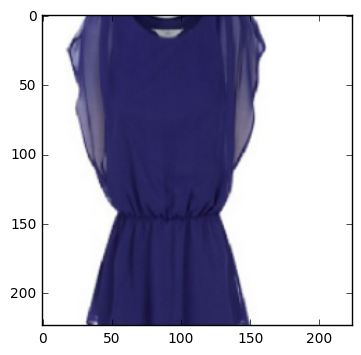

<type 'numpy.ndarray'>


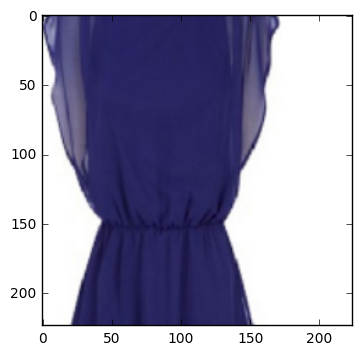

<type 'numpy.ndarray'>


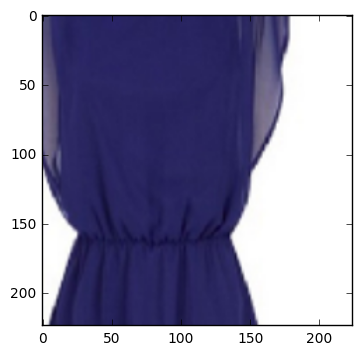

<type 'numpy.ndarray'>


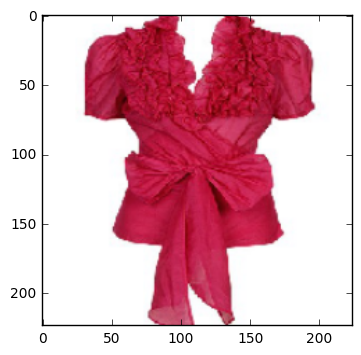

<type 'numpy.ndarray'>


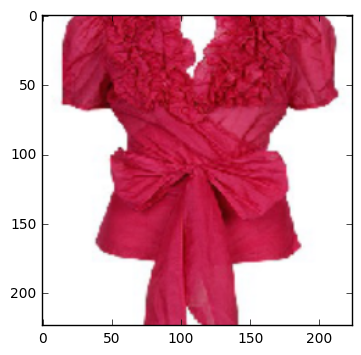

<type 'numpy.ndarray'>


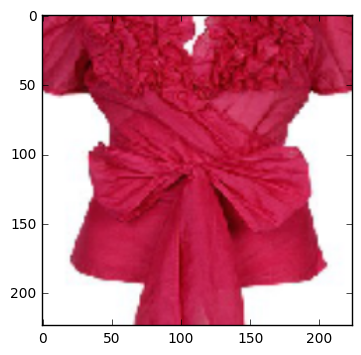

In [95]:
for image in scaled_imgs:    
    print type(image)
    plt.imshow(image)
    plt.show()